In [2]:
import tensorflow as tf
from model.generator import read_fasta_as_one_hot_encoded
import numpy as np
import matplotlib.pyplot as plt
from dca.dca_class import dca,return_Hamiltonian,create_numerical_MSA
import pandas as pd 
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from os.path import isfile
import networkx as nx
from Bio import SeqIO
from Bio.SeqRecord  import SeqRecord
from Bio.Seq import Seq
from scipy.stats import pearsonr
from hamiltonian_map import Generative_Functions

2025-06-27 16:49:28.590100: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### **Fasta of Latent Space** ###

In [12]:
output_path = 'trpm/all_grid.fasta' # grid output
full_alignment = "trpm/zed.fasta" # Family MSA
pixels = 500 # N^2 grid of sequences will be produced
def get_grid_hamiltonian(mfdcamodel,all_grid_path):
    hamil_mat,coords=mfdcamodel.compute_Hamiltonian(all_grid_path)
    print(coords[0],coords[-1])
    return hamil_mat.reshape((500,500)),float(coords[0]),float(coords[-1])
mfdcamodel = dca(full_alignment)
mfdcamodel.mean_field()
hamiltonian_3di=mfdcamodel.compute_Hamiltonian(full_alignment)
hamil_mat,ax_min,ax_max=get_grid_hamiltonian(mfdcamodel=mfdcamodel,all_grid_path=output_path)


-6.0 6.0


### **Visualize Input Training Data** ###

In [9]:
zed_train =np.array([[float(str(i.description).split(" ")[0]),float(str(i.description).split(" ")[1])] for i in SeqIO.parse("/lustre/hdd/LAS/potoyan-lab/Divyanshu/git-repos/3Di_Landscape/trpm/zed.fasta","fasta")])

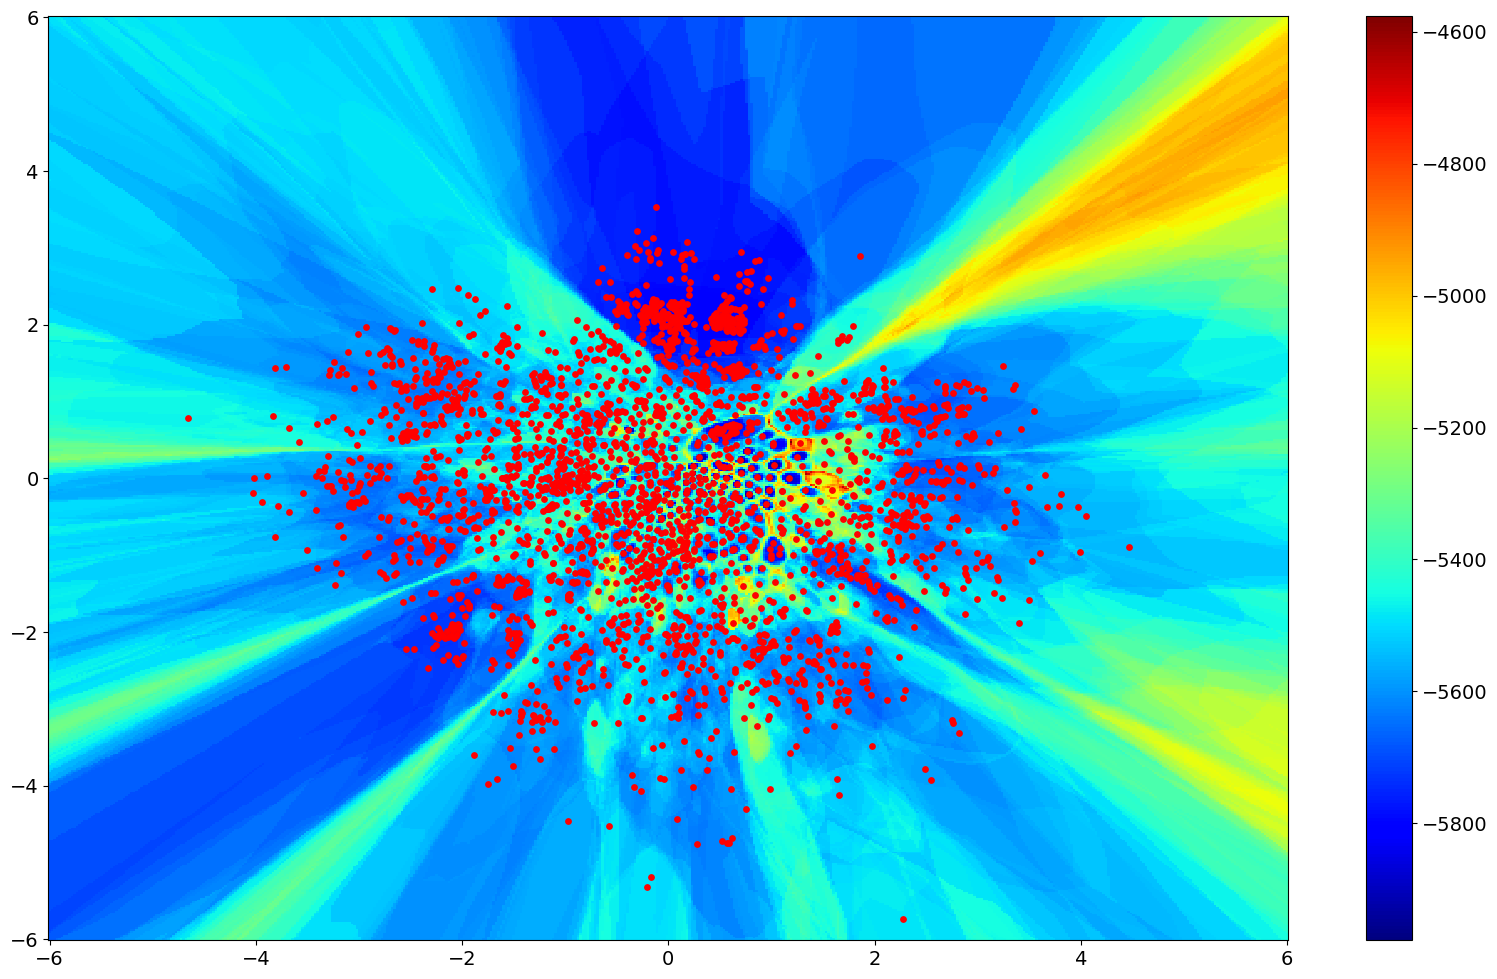

In [10]:
plt.rcParams.update({'font.size': 14})
resolution = [ax_min, ax_max, pixels]
a, b = np.meshgrid(np.linspace(resolution[0], resolution[1], resolution[2]),
                       np.linspace(resolution[0], resolution[1], resolution[2]))
fig, ax = plt.subplots()
fig.set_size_inches([20,12])
c = ax.pcolormesh(b, a, hamil_mat, cmap='jet')
fig.colorbar(c, ax=ax)
plt.scatter(zed_train[:,0],zed_train[:,1],s=15,c='red')
plt.show()

### **DCA Analysis of Input Fasta** ###
#### DI(Direct Information) Contacts Calulated by DCA ####

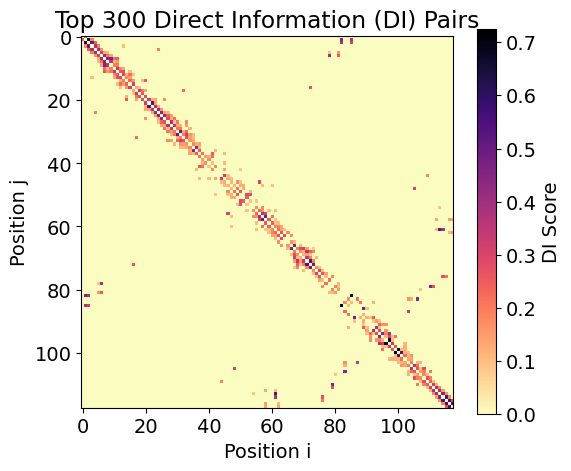

In [13]:

mfdcamodel = dca("globin/new_generated.fasta")
mfdcamodel.mean_field()
hamiltonian_3di=mfdcamodel.compute_Hamiltonian("globin/new_generated.fasta")
direct = np.zeros((mfdcamodel.N, mfdcamodel.N))

# Extract all DI values with their indices
di_list = []
count = 0
for i in range(mfdcamodel.N):
    for j in range(i + 1, mfdcamodel.N):
        di_score = mfdcamodel.DI[count][2]
        di_list.append((i, j, di_score))
        count += 1

# Sort by DI score descending and select top N
N = 300  # change to desired number of top pairs
top_di = sorted(di_list, key=lambda x: x[2], reverse=True)[:N]

# Fill upper triangle with top N DI scores
for i, j, score in top_di:
    direct[i, j] = score
    direct[j, i] = score

# Plot the upper triangle matrix
plt.figure(figsize=(6, 5))
plt.imshow(direct, cmap='magma_r')
plt.title(f"Top {N} Direct Information (DI) Pairs")
plt.colorbar(label='DI Score')
plt.xlabel("Position i")
plt.ylabel("Position j")
plt.show()


#### Correlation Between Generated and Training DCA Score ####

In [18]:
mat,ax_min,ax_max=get_grid_hamiltonian(mfdcamodel=mfdcamodel,all_grid_path="globin/all_grid.fasta")
zed=np.array([[float(str(i.description).split(" ")[0]),float(str(i.description).split(" ")[1])] for i in SeqIO.parse("globin/zed.fasta","fasta")])
thresholds=[0.0]
numseq_r=[]
for threshold in thresholds:
    generate_hamil=[]
    relevant_hamil=[]
    for j,i in enumerate(zed):
        if ((i[0]>threshold or i[0]<-threshold) and (i[1]>threshold or i[1]<-threshold)):
            generate_hamil.append(mat[int((i[0]-ax_min)*500/(2*ax_max)),int((i[1]-ax_min)*500/(2*ax_max))])
            relevant_hamil.append(hamiltonian_3di[0][j])
    if (len(generate_hamil)>200):
        r_value, p_value = pearsonr(generate_hamil,relevant_hamil)
        numseq_r.append([r_value,len(generate_hamil)])
    else:
        break
generate_hamil=np.array(generate_hamil)
relevant_hamil=np.array(relevant_hamil)
numseq_r=np.asarray(numseq_r)

-6.0 6.0


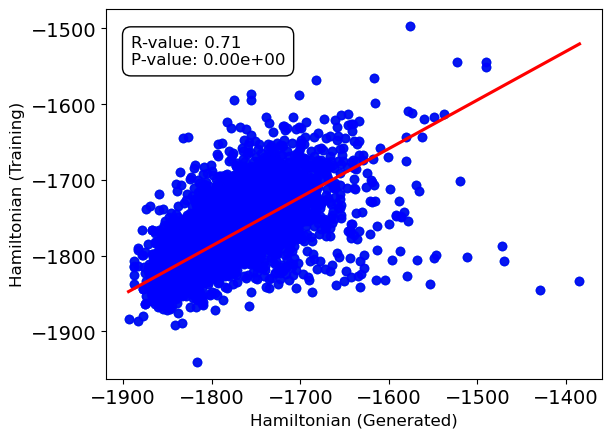

In [7]:
plt.scatter(generate_hamil,relevant_hamil)
sns.regplot(x=generate_hamil, y=relevant_hamil, scatter=True, ci=None, line_kws={"color": "red"},color='blue')
plt.text(0.05, 0.85, f'R-value: {r_value:.2f}\nP-value: {p_value:.2e}', transform=plt.gca().transAxes, fontsize=12, color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
# plt.text(0.02, 0.85, f'P-value: {p_value:.2e}', transform=plt.gca().transAxes, fontsize=12, color='black')
plt.xlabel("Hamiltonian (Generated)", fontsize=12)
plt.ylabel("Hamiltonian (Training)", fontsize=12)
plt.show()

### Function Based Clustering ###

In [15]:
index={"cytoglobin":[],"myoglobin":[],"flavohemoglobin":[],"neuroglobin":[],"leghemoglobin":[],"cryobacterium":[],"hemo_alpha":[],"hemo_beta":[]}
index_id={}
c=0
for i in list(SeqIO.parse("globin/new_generated.fasta", "fasta")):
    if "cytoglobin" in i.description.lower():
        index["cytoglobin"].append([zed[int(c)][0],zed[int(c)][1]])
        index_id.update({f"{zed[int(c)][0]},{zed[int(c)][1]}":i.id})
    elif "myoglobin" in i.description.lower():
        index["myoglobin"].append([zed[int(c)][0],zed[int(c)][1]])
        index_id.update({f"{zed[int(c)][0]},{zed[int(c)][1]}":i.id})
    elif "flavo" in i.description.lower() :
    # and ("F4FH74" in i or "A0A0N0LWZ5" in i or "A0A1D8T7A6" in i or "T0GA81" in i or "A0A1H7CNG1" in i or
    #                                     "A0A0X8GLM9" in i or "A0A5C4WKN4" in i or "A0A543FJ13" in i or "A0A4V3CQR8" in i or
    #                                     "A0A1H0XPG8" in i or "A0A1D8UY24" in i):
        index["flavohemoglobin"].append([zed[int(c)][0],zed[int(c)][1]])
        index_id.update({f"{zed[int(c)][0]},{zed[int(c)][1]}":i.id})
    elif "neuroglobin" in i.description.lower():
        index["neuroglobin"].append([zed[int(c)][0],zed[int(c)][1]])
        index_id.update({f"{zed[int(c)][0]},{zed[int(c)][1]}":i.id})
    elif "leghemoglobin" in i.description.lower():
        index["leghemoglobin"].append([zed[int(c)][0],zed[int(c)][1]])
        index_id.update({f"{zed[int(c)][0]},{zed[int(c)][1]}":i.id})
    elif ("bacteri" in i.description.lower() and " hemoglobin" in i.description.lower()):
    # or "q0p842" in i.lower() or "i1sba3"in i.lower():
        index["cryobacterium"].append([zed[int(c)][0],zed[int(c)][1]])
        index_id.update({f"{zed[int(c)][0]},{zed[int(c)][1]}":i.id})
    elif "subunit alpha" in i.description.lower():
    # and ("bos taurus" in i.lower() or"felis catus" in i.lower() or "homo sapiens" in i.lower() or "capra hircus" in i.lower() or "equus caballus" in i.lower() or
    #                                     "canis lupus familiaris" in i.lower() or "camelus dromedarius" in i.lower() or "cavia porcellus" in i.lower() or "odocoileus virginianus" in i.lower() or
    #                                     "oryctolagus cuniculus" in i.lower() or "ovis aries" in i.lower() or "rattus norvegicus" in i.lower() or "sus scrofa" in i.lower()):
        index["hemo_alpha"].append(zed[int(c)])
        index_id.update({f"{zed[int(c)][0]},{zed[int(c)][1]}":i.id})
    elif "subunit beta" in i.description.lower():
    # and ("bos taurus" in i.lower() or"felis catus" in i.lower() or "homo sapiens" in i.lower() or "capra hircus" in i.lower() or "equus caballus" in i.lower() or
    #                                     "canis lupus familiaris" in i.lower() or "camelus dromedarius" in i.lower() or "cavia porcellus" in i.lower() or "odocoileus virginianus" in i.lower() or
    #                                     "oryctolagus cuniculus" in i.lower() or "ovis aries" in i.lower() or "rattus norvegicus" in i.lower() or "sus scrofa" in i.lower()):
        index["hemo_beta"].append(zed[int(c)])
        index_id.update({f"{zed[int(c)][0]},{zed[int(c)][1]}":i.id})
    c+=1
coord_train=np.asarray([np.asarray(index[i]) for i in index.keys()])

/tmp/ipykernel_162742/3971226289.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  coord_train=np.asarray([np.asarray(index[i]) for i in index.keys()])


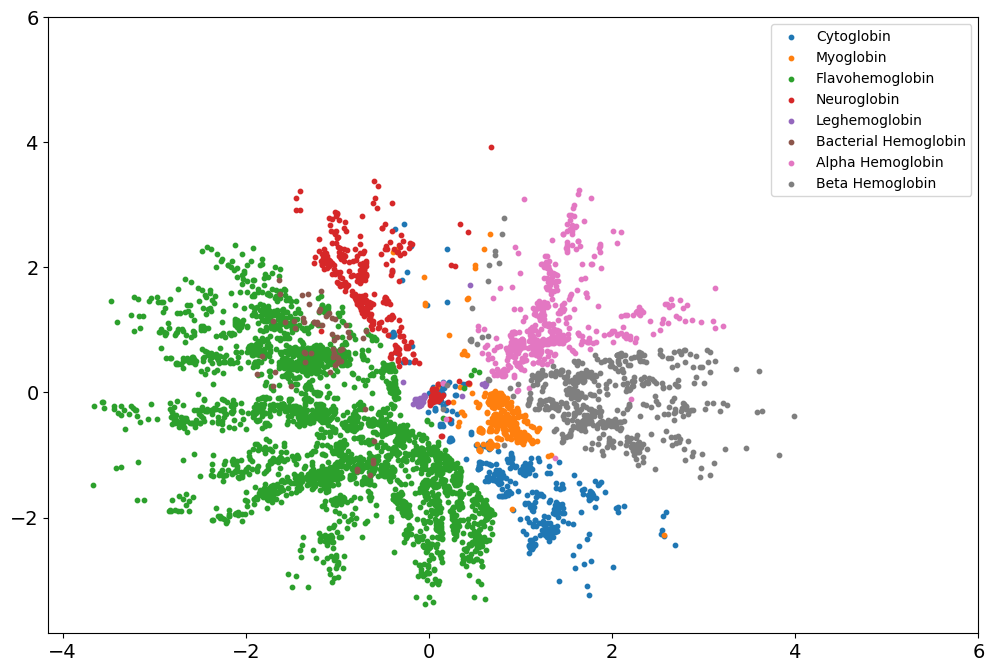

In [17]:
plt.rcParams.update({'font.size': 14})
resolution = [ax_max, ax_max, 500]
a, b = np.meshgrid(np.linspace(resolution[0], resolution[1], resolution[2]),
                       np.linspace(resolution[0], resolution[1], resolution[2]))
fig, ax = plt.subplots()
fig.set_size_inches([12,8])
c = ax.pcolormesh(b, a, mat, cmap='jet')
plt.scatter(x=coord_train[0][:,0],y=coord_train[0][:,1],s=10)
plt.scatter(x=coord_train[1][:,0],y=coord_train[1][:,1],s=10)
plt.scatter(x=coord_train[2][:,0],y=coord_train[2][:,1],s=10)
plt.scatter(x=coord_train[3][:,0],y=coord_train[3][:,1],s=10)
plt.scatter(x=coord_train[4][:,0],y=coord_train[4][:,1],s=10)
plt.scatter(x=coord_train[5][:,0],y=coord_train[5][:,1],s=10)
plt.scatter(x=coord_train[6][:,0],y=coord_train[6][:,1],s=10)
plt.scatter(x=coord_train[7][:,0],y=coord_train[7][:,1],s=10)
plt.legend(["Cytoglobin","Myoglobin","Flavohemoglobin","Neuroglobin","Leghemoglobin","Bacterial Hemoglobin","Alpha Hemoglobin","Beta Hemoglobin"],fontsize=10)
plt.show()